In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio

print(torch.__version__)
print(torchaudio.__version__)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from torchaudio.datasets import SPEECHCOMMANDS
import os
import torch.nn as nn
import torch.nn.functional
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
class SubsetSC(SPEECHCOMMANDS):
    """
    A class representing a subset of the Speech Commands dataset.

    Args:
        subset (str, optional): The subset to load. Can be one of "validation", "testing", or "training". Defaults to None.
        url (str, optional): The URL to download the dataset from. Defaults to "speech_commands_v0.01".

    Attributes:
        _walker (list): A list of file paths representing the subset.

    """

    def __init__(self, subset: str = None, url="speech_commands_v0.01"):
        super().__init__("./", url=url, download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [
                    os.path.normpath(os.path.join(self._path, line.strip()))
                    for line in fileobj
                ]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")
valid_set = SubsetSC("validation")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

In [ ]:
print("length of train_set: ", len(train_set))
print("length of test_set: ", len(test_set))
print("length of valid_set: ", len(valid_set))

In [ ]:
def print_def(sample):
    print(
        "Waveform: {}\nSample rate: {}\nLabel: {}\nSpeaker ID: {}\nUtterance number: {}".format(
            sample[0], sample[1], sample[2], sample[3], sample[4]
        )
    )

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy())

Let’s find the list of labels available in the dataset.


In [ ]:
words = [
    "bed",
    "bird",
    "cat",
    "dog",
    "down",
    "eight",
    "five",
    "four",
    "go",
    "happy",
    "house",
    "left",
    "marvin",
    "nine",
    "no",
    "off",
    "on",
    "one",
    "right",
    "seven",
    "sheila",
    "six",
    "stop",
    "three",
    "tree",
    "two",
    "up",
    "wow",
    "yes",
    "zero",
]

We are encoding each word using its index in the list of labels.


In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(words.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return words[index]


# Test
word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

In [ ]:
    

# Add background noise
    if background_noise_dir:
        background_noise_files = os.listdir(background_noise_dir)
        background_noise_path = os.path.join(background_noise_dir, random.choice(background_noise_files))
        background_waveform, _ = torchaudio.load(background_noise_path, normalize=True)
        background_waveform = background_waveform.to(device)
        # Make sure the background noise waveform is the same length as the input waveform
        if background_waveform.size(1) < waveform.size(1):
            background_waveform = torch.nn.functional.pad(
                background_waveform, (0, waveform.size(1) - background_waveform.size(1))
            )
        elif background_waveform.size(1) > waveform.size(1):
            background_waveform = background_waveform[:, : waveform.size(1)]
        # Mix the background noise with the input waveform, you can adjust the level to control the loudness of the background noise
        waveform += background_waveform * 0.1

In [ ]:
# extraction des features mfcc

n_fft = 1024
n_mels = 64
n_mfcc = 64
hop_length = int(0.01 * 16000)  # 10 ms en échantillons
win_length = int(0.025 * 16000)  # 25 ms en échantillons
sample_rate = 16000

# MFCC transform object
mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "win_length": win_length,
        "mel_scale": "htk",
    },
).to(device)


# Fonction pour l'augmentation des données
def data_augmentation(
    waveform,
    time_shift=False,
    noise=False,
    time_masking_b=False,
    frequency_masking_b=False,
    spec_cutout=False,
):
    # Time shift perturbation
    if time_shift:
        shift_ms = random.uniform(-100, 100)
        shift_samples = int(sample_rate * shift_ms / 1000)
        waveform = torch.roll(waveform, shifts=shift_samples, dims=-1)

    # Add white noise with magnitude [-90, -46] dB
    if noise:
        noise_dB = random.uniform(-90, -46)
        noise_power = torch.pow(10.0, noise_dB / 10)
        noise = torch.randn(waveform.size(), device=device) * noise_power
        waveform += noise

    # Apply SpecAugment
    # 2 continuous time masks of size [0, 25] time steps
    if time_masking_b:
        time_masking = T.TimeMasking(time_mask_param=random.randint(0, 25)).to(device)
        waveform = time_masking(waveform)
        waveform = time_masking(waveform)  # Apply twice for 2 continuous time masks

    if frequency_masking_b:
        # 2 continuous frequency masks of size [0, 15] frequency bands
        frequency_masking = T.FrequencyMasking(
            freq_mask_param=random.randint(0, 15)
        ).to(device)
        waveform = frequency_masking(waveform)
        waveform = frequency_masking(
            waveform
        )  # Apply twice for 2 continuous frequency masks

    return waveform

In [ ]:
def extract_mfcc(batch):

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:

        if waveform.size(1) < 16000:
            # Pad the waveform if it is shorter than 1 second
            waveform = torch.nn.functional.pad(
                waveform, (0, sample_rate - waveform.size(1)), value=0
            )
        elif waveform.size(1) > 16000:
            # Trim the waveform if it is longer than 1 second
            waveform = waveform[:, :16000]

        # Apply data augmentation to the waveform
        waveform = waveform.to(device)
        waveform_augmented = data_augmentation(
            waveform, time_shift=True
        )  # Uncomment to apply time shift perturbation
        # waveform = data_augmentation(waveform, time_shift=True, spec_augment=True) # Uncomment to apply time shift perturbation and SpecAugment
        # Apply MFCC transform to the waveform
        waveform = mfcc_transform(waveform)

        # Apply MFCC transform to the waveform
        waveform_augmented = mfcc_transform(waveform_augmented)

        # Reshape the waveform
        waveform_augmented = waveform.reshape(1, -1)

        # Reshape the waveform
        waveform = waveform.reshape(1, -1)

        tensors += [waveform]
        tensors += [waveform_augmented]
        targets += [label_to_index(label)]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = torch.stack(tensors)
    targets = torch.stack(targets)

    return tensors.squeeze(1), targets


[1, 40, 89]

In [ ]:
batch_size = 256  # Batch size for training

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

# Create the dataloaders for training, validation, and testing
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=extract_mfcc,  # Apply the data processing function to the minibatch
    num_workers=num_workers,
    pin_memory=pin_memory,
)
validation_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=extract_mfcc,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
# implémentation d'un modèle pas très complexe


class SimpleNeuralNet(nn.Module):
    """

    A simple neural network model for classification tasks.





    Args:




        input_size (int): The number of input features.




        hidden_size (int): The number of units in the hidden layer.




        num_classes (int): The number of output classes.




    """

    def __init__(self, input_size, hidden_size, num_classes):

        super(SimpleNeuralNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)

        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        Forward pass of the neural network.
        Args:
            x (torch.Tensor): The input tensor.
        Returns:
            torch.Tensor: The output tensor.
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = SimpleNeuralNet(input_size=6464, hidden_size=500, num_classes=30).to(device)
print(model)

# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fonction d'entraînement


def train(model, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        print(target.shape)
        data, target = data.to(device), target.to(
            device
        )  # Charger les données sur le GPU
        output = model(data)  # Prédiction du modèle
        loss = criterion(output, target)  # Calcul de la perte
        optimizer.zero_grad()  # Remettre à zéro les gradients
        loss.backward()  # Calcul des gradients
        optimizer.step()  # Mise à jour des poids
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


# Fonction d'évaluation


def test_validation(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += (
                pred.eq(target.view_as(pred)).sum().item()
            )  # Number of correct predictions

    test_loss /= len(validation_loader.dataset)  # Average loss
    print(
        "\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(validation_loader.dataset),
            100.0 * correct / len(validation_loader.dataset),
        )
    )


# Entraînement du modèle

for epoch in range(1, 11):
    train(model, epoch)
    test_validation(model)

In [ ]:
# Fonction d'évaluation
def evaluate(model, data_loader):
    model.eval()  # Mettre le modèle en mode évaluation
    predictions = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())

    return predictions, targets


# Obtenir les prédictions et les cibles
test_predictions, test_targets = evaluate(model, test_loader)

# Afficher les performances
print("Test Classification Report:")
print(classification_report(test_targets, test_predictions, target_names=words))

# Matrice de confusion
cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Tester en utilisant l'augmentation des données : time_shift, time_masking and frequency_masking.

#### Exemple de `time_masking` et `frequency_masking` sur un spectrogramme de 3 secondes :\*\*

<div style="background-color:white;">

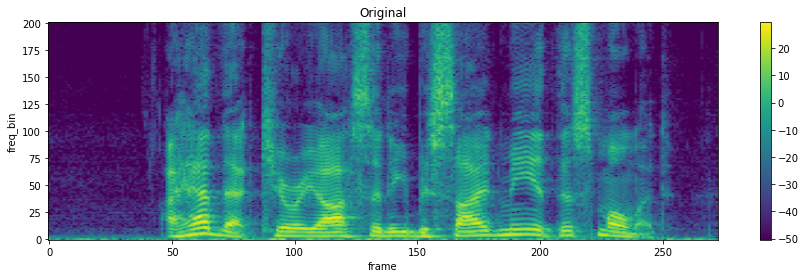
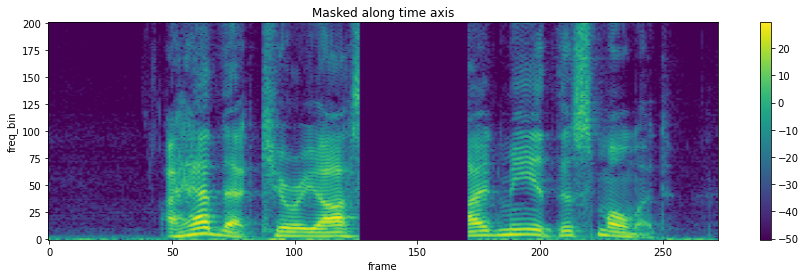
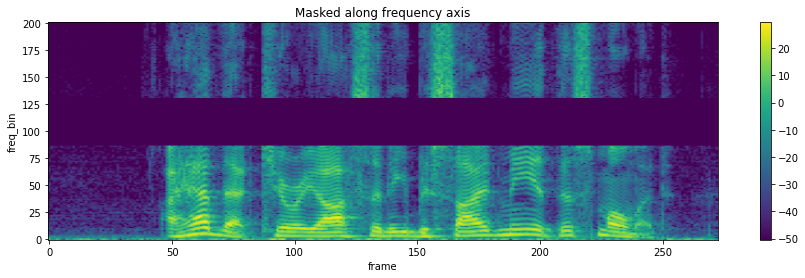

</div>


In [ ]:
# je vais modifier les params de augmentantion des données dans extract_mfcc et mettre a true spec_augment pour
# le time_masking et frequency_masking
# pour voir si cela améliore les performances du modèle
# (deja fait)

# Entraînement du modèle
for epoch in range(1, 10):
    train(model, epoch)
    test_validation(model)

In [ ]:
# Obtenir les prédictions et les cibles
test_predictions, test_targets = evaluate(model, test_loader)

# Afficher les performances
print("Test Classification Report:")
print(classification_report(test_targets, test_predictions, target_names=words))

# Matrice de confusion
cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Regression Logistique


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from random import randint

In [ ]:
def flatten(loader):
    data_list = []
    label_list = []
    for data, label in loader:
        data_list.append(data.view(data.size(0), -1).numpy())
        label_list.append(label.numpy())
    return np.vstack(data_list), np.hstack(label_list)

In [ ]:
# Flatten the data
train_data, train_labels = flatten(train_loader)
valid_data, valid_labels = flatten(validation_loader)
test_data, test_labels = flatten(test_loader)

# Define the model
model = LogisticRegression()

# Train the model
model.fit(train_data, train_labels)

# Predict on validation data
valid_pred = model.predict(valid_data)

# Print the classification report, confusion matrix, accuracy score for validation data
print("Validation Data:")
print("Classification Report:\n", classification_report(valid_labels, valid_pred))
# print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_pred))
cm_valid = confusion_matrix(valid_labels, valid_pred)
print("Accuracy Score: ", accuracy_score(valid_labels, valid_pred))

# Predict on test data
test_pred = model.predict(test_data)

# Print the classification report, confusion matrix, accuracy score for test data
print("Test Data:")
print("Classification Report:\n", classification_report(test_labels, test_pred))
# print("Confusion Matrix:\n", confusion_matrix(test_labels, test_pred))
cm_test = confusion_matrix(test_labels, test_pred)
print("Accuracy Score: ", accuracy_score(test_labels, test_pred))

In [ ]:
# Matrice de confusion (validation)

plt.figure(figsize=(10, 10))
plt.imshow(cm_valid, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Matrice de confusion (test)

plt.figure(figsize=(10, 10))
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()